In [ ]:
##import libraries

import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import IPython.display as display
from matplotlib import pyplot as plt
import io
import base64
import re
from IPython.display import display, HTML, Image

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql.functions import col
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from google.colab import drive
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator
import statsmodels.api as sm


In [ ]:
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!sudo apt update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#Check this site for the latest download link https://www.apache.org/dyn/closer.lua/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
!pip install -q findspark
!pip install pyspark
!pip install py4j

import os
import sys
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"


import findspark
findspark.init()
findspark.find()

import pyspark

from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

spark= SparkSession \
       .builder \
       .appName("Our First Spark Example") \
       .getOrCreate()

spark


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,775 kB]
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,978 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-secur

In [ ]:
# pip install ucimlrepo

# **read data file**

In [ ]:
import pandas as pd
import io
import requests

path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx'

# Fetch the Excel file content from the URL
response = requests.get(path)
response.raise_for_status()  # Raise an exception for bad responses

# Read the Excel data into a pandas DataFrame
df = pd.read_excel(io.BytesIO(response.content), engine='openpyxl')

In [ ]:
# from ucimlrepo import fetch_ucirepo

# # fetch dataset
# online_retail = fetch_ucirepo(id=352)

# # data (as pandas dataframes)
# X = online_retail.data.features
# y = online_retail.data.targets
# # metadata
# print(online_retail.metadata)

# # variable information
# print(online_retail.variables)


{'uci_id': 352, 'name': 'Online Retail', 'repository_url': 'https://archive.ics.uci.edu/dataset/352/online+retail', 'data_url': 'https://archive.ics.uci.edu/static/public/352/data.csv', 'abstract': 'This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.', 'area': 'Business', 'tasks': ['Classification', 'Clustering'], 'characteristics': ['Multivariate', 'Sequential', 'Time-Series'], 'num_instances': 541909, 'num_features': 6, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': None, 'index_col': ['InvoiceNo', 'StockCode'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2015, 'last_updated': 'Mon Oct 21 2024', 'dataset_doi': '10.24432/C5BW33', 'creators': ['Daqing Chen'], 'intro_paper': {'ID': 361, 'type': 'NATIVE', 'title': 'Data mining for the online retail industry: A case study of RFM model-based customer segmenta

# EDA

In [ ]:
df.tail(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [ ]:
# Check the column level Null %
# Check data Type of each of the column
temp_df = pd.DataFrame((df.isnull().sum()/df.shape[0])*100,columns=['Null value%'])
temp_df['data_type'] = df.dtypes
temp_df.T

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null value%,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0
data_type,object,object,object,int64,datetime64[ns],float64,float64,object


In [ ]:
# uk_df = df[df['Country'] == 'United Kingdom']
# uk_df.to_csv('/content/drive/My Drive/uk_df.csv', index=False)

uk_df=pd.read_csv('/content/drive/My Drive/uk_df.csv')

In [ ]:
print("Total Numbers of Rows in data set",uk_df.shape[0])
print("Total Numbers of columns in data set",uk_df.shape[1])
print(f"Most Expensive Product of data: ${uk_df['UnitPrice'].max()}GBP")
print(f"Cheapest Product of data: ${uk_df['UnitPrice'].min()}GBP")

Total Numbers of Rows in data set 495478
Total Numbers of columns in data set 6
Most Expensive Product of data: $38970.0GBP
Cheapest Product of data: $-11062.06GBP


In [ ]:
# Check the column level Null %
# Check data Type of each of the column
temp_df = pd.DataFrame((uk_df.isnull().sum()/uk_df.shape[0])*100,columns=['Null value%'])
temp_df['data_type'] = uk_df.dtypes
temp_df.T

,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null value%,0.293454,0.0,0.0,0.0,26.963861,0.0
data_type,object,int64,object,float64,float64,object


In [ ]:
uk_df.isnull().count()

,0
InvoiceNo,495478
StockCode,495478
Description,495478
Quantity,495478
InvoiceDate,495478
UnitPrice,495478
CustomerID,495478
Country,495478


# convert to pyspark


In [ ]:
temp_df = spark.createDataFrame(uk_df)

In [ ]:
temp_df.summary().show()

+-------+------------------+------------------+--------------------+------------------+-----------------+----------+--------------+
|summary|         InvoiceNo|         StockCode|         Description|          Quantity|        UnitPrice|CustomerID|       Country|
+-------+------------------+------------------+--------------------+------------------+-----------------+----------+--------------+
|  count|            495478|            495478|              495478|            495478|           495478|    495478|        495478|
|   mean| 559946.5806644121|27811.351033077117|                 NaN| 8.605486015524402|4.532422174138707|       NaN|          NULL|
| stddev|13508.946524704916| 17074.96156073609|                 NaN|227.58875610852985|99.31543833203035|       NaN|          NULL|
|    min|            536365|             10002| 4 PURPLE FLOCK D...|            -80995|        -11062.06|   12346.0|United Kingdom|
|    25%|          547860.0|           21928.0|                 NaN|        

In [ ]:
temp_df.select('InvoiceNo').distinct().count()

23494

In [ ]:
temp_df.filter(F.col('UnitPrice')>1000).select('InvoiceNo').distinct().count()

86

In [ ]:
temp_df.filter(F.col('UnitPrice')>1000).select('Description','StockCode').distinct()
admin_charge = temp_df.filter(F.col('UnitPrice')>1000).select('StockCode').distinct()

In [ ]:
discount_invoice = temp_df.filter(F.col('Description').isin('Discount')).limit(1).select('CustomerID').distinct()
temp_df.join(discount_invoice,'CustomerID','inner').sort('InvoiceDate').show()

+----------+---------+---------+--------------------+--------+-------------------+---------+--------------+
|CustomerID|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|       Country|
+----------+---------+---------+--------------------+--------+-------------------+---------+--------------+
|   14527.0|  C536379|        D|            Discount|      -1|2010-12-01 09:41:00|     27.5|United Kingdom|
|   14527.0|   537159|    22112|CHOCOLATE HOT WAT...|       6|2010-12-05 13:17:00|     4.95|United Kingdom|
|   14527.0|   537159|    22111|SCOTTIE DOG HOT W...|       1|2010-12-05 13:17:00|     4.95|United Kingdom|
|   14527.0|   537159|    21479|WHITE SKULL HOT W...|       1|2010-12-05 13:17:00|     3.75|United Kingdom|
|   14527.0|   537159|    22114|HOT WATER BOTTLE ...|       6|2010-12-05 13:17:00|     3.95|United Kingdom|
|   14527.0|   537159|   35598B|BLACK CHRISTMAS T...|       1|2010-12-05 13:17:00|     2.95|United Kingdom|
|   14527.0|   537159|    22

In [ ]:
temp_df.filter(F.col('InvoiceNo').contains('C')).select('InvoiceNo').distinct().count()

3372

In [ ]:
temp_df.filter(F.col('InvoiceNo').contains('C')).select('InvoiceNo').distinct().show()

+---------+
|InvoiceNo|
+---------+
|  C542604|
|  C546174|
|  C549913|
|  C556414|
|  C540347|
|  C542245|
|  C548738|
|  C550614|
|  C552015|
|  C552019|
|  C552919|
|  C553370|
|  C557154|
|  C557654|
|  C557656|
|  C559344|
|  C560044|
|  C539068|
|  C547495|
|  C549930|
+---------+
only showing top 20 rows



In [ ]:
# ##discount have a different invoice number and date, cannot map back to the original transaction with stock code and item name-- highlight
# transaction_to_check = temp_df.filter(F.col('Description').isin('Discount')).select('InvoiceNo').distinct().limit(5)
# temp_df.join(transaction_to_check,'InvoiceNo','inner').show()

+---------+---------+-----------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+-----------+--------+-------------------+---------+----------+--------------+
|  C540171|        D|   Discount|      -1|2011-01-05 12:26:00|    22.97|   14527.0|United Kingdom|
|  C545478|        D|   Discount|    -720|2011-03-03 11:08:00|     0.01|   16422.0|United Kingdom|
|  C548411|        D|   Discount|      -1|2011-03-31 10:36:00|   162.24|   13316.0|United Kingdom|
|  C549452|        D|   Discount|      -1|2011-04-08 14:17:00|  1867.86|   17940.0|United Kingdom|
|  C556904|        D|   Discount|      -1|2011-06-15 12:56:00|    14.42|   14527.0|United Kingdom|
+---------+---------+-----------+--------+-------------------+---------+----------+--------------+



In [ ]:
##add date time columns
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
temp_df=temp_df.distinct()\
.withColumn('revenue',F.col('Quantity')*F.col('UnitPrice'))\
.withColumn('invoice_date',F.to_timestamp(F.col("InvoiceDate"),'MM/dd/yyyy'))\
.withColumn('invoice_date_only',F.to_date("invoice_date"))\
.withColumn('invoice_month',F.month("invoice_date"))\
.withColumn('invoice_year',F.year("invoice_date"))\
.withColumn('day_of_week', F.weekday('invoice_date'))\
.withColumn('day_of_week_str', F.date_format('invoice_date', 'E'))

In [ ]:
temp_df.select(F.col('day_of_week_str')).distinct().show()
##no saturday data

+---------------+
|day_of_week_str|
+---------------+
|            Sun|
|            Mon|
|            Thu|
|            Wed|
|            Fri|
|            Tue|
+---------------+



In [ ]:
temp_df.select(F.col('invoice_date_only')).distinct().sort(F.col('invoice_date_only').desc()).show()

+-----------------+
|invoice_date_only|
+-----------------+
|       2011-12-09|
|       2011-12-08|
|       2011-12-07|
|       2011-12-06|
|       2011-12-05|
|       2011-12-04|
|       2011-12-02|
|       2011-12-01|
|       2011-11-30|
|       2011-11-29|
|       2011-11-28|
|       2011-11-27|
|       2011-11-25|
|       2011-11-24|
|       2011-11-23|
|       2011-11-22|
|       2011-11-21|
|       2011-11-20|
|       2011-11-18|
|       2011-11-17|
+-----------------+
only showing top 20 rows



In [ ]:
temp_df.select(F.min('invoice_date')).show()
temp_df.select(F.max('invoice_date')).show()

+-------------------+
|  min(invoice_date)|
+-------------------+
|2010-12-01 00:00:00|
+-------------------+

+-------------------+
|  max(invoice_date)|
+-------------------+
|2011-12-09 00:00:00|
+-------------------+



In [ ]:
temp_df.filter(F.col('Description')=='NaN').select('InvoiceNo').distinct().count()

1454

what happens when quantity ===0? price ==0?

In [ ]:
temp_df.filter(F.col('Quantity')==0).show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+
|InvoiceNo|StockCode|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|
+---------+---------+-----------+--------+-----------+---------+----------+-------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+



In [ ]:
##what could have caused unit price == 0? wholesale discount & return when unit is negative?
temp_df.filter(F.col('UnitPrice')==0).select('InvoiceNo').distinct().count()

2141

In [ ]:
temp_df.filter(F.col('Quantity')<0).filter(~F.col('Description').isin('NaN')).show()

+--------------------+--------+----------------+---------+----------+--------------+-------+-------------------+-------------+------------+-----------+
|         Description|Quantity|     InvoiceDate|UnitPrice|CustomerID|       Country|revenue|       invoice_date|invoice_month|invoice_year|day_of_week|
+--------------------+--------+----------------+---------+----------+--------------+-------+-------------------+-------------+------------+-----------+
|            Discount|      -1| 12/7/2010 12:34|    281.0|   15498.0|United Kingdom| -281.0|2010-12-07 12:34:00|           12|        2010|        Tue|
|BLUE POLKADOT PLATE |      -8| 12/8/2010 16:15|     1.69|   16252.0|United Kingdom| -13.52|2010-12-08 16:15:00|           12|        2010|        Wed|
| TOADSTOOL MONEY BOX|      -1|12/13/2010 13:09|     2.95|   17231.0|United Kingdom|  -2.95|2010-12-13 13:09:00|           12|        2010|        Mon|
|RED RETROSPOT CAK...|      -1|12/16/2010 15:28|    10.95|   14639.0|United Kingdom| -10

In [ ]:
temp_df.filter(F.col('UnitPrice')<0).show()

+---------------+--------+---------------+---------+----------+--------------+---------+-------------------+-------------+------------+-----------+
|    Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|  revenue|       invoice_date|invoice_month|invoice_year|day_of_week|
+---------------+--------+---------------+---------+----------+--------------+---------+-------------------+-------------+------------+-----------+
|Adjust bad debt|       1|8/12/2011 14:51|-11062.06|       NaN|United Kingdom|-11062.06|2011-08-12 14:51:00|            8|        2011|        Fri|
|Adjust bad debt|       1|8/12/2011 14:52|-11062.06|       NaN|United Kingdom|-11062.06|2011-08-12 14:52:00|            8|        2011|        Fri|
+---------------+--------+---------------+---------+----------+--------------+---------+-------------------+-------------+------------+-----------+



In [ ]:
temp_df.filter(F.col('CustomerID')=='NaN').limit(10).show()

+--------------------+--------+---------------+---------+----------+--------------+------------------+-------------------+-------------+------------+-----------+
|         Description|Quantity|    InvoiceDate|UnitPrice|CustomerID|       Country|           revenue|       invoice_date|invoice_month|invoice_year|day_of_week|
+--------------------+--------+---------------+---------+----------+--------------+------------------+-------------------+-------------+------------+-----------+
|PACK OF 6 HANDBAG...|       1|12/1/2010 14:32|     5.06|       NaN|United Kingdom|              5.06|2010-12-01 14:32:00|           12|        2010|        Wed|
|EUCALYPTUS & PINE...|       7|12/1/2010 17:06|     5.91|       NaN|United Kingdom|41.370000000000005|2010-12-01 17:06:00|           12|        2010|        Wed|
|BLUE VICTORIAN FA...|       1|12/1/2010 17:06|     0.84|       NaN|United Kingdom|              0.84|2010-12-01 17:06:00|           12|        2010|        Wed|
|3 TIER CAKE TIN G...|      

In [ ]:
temp_df.filter(F.col('CustomerID')=='NaN').count()

132909

In [ ]:
temp_df.filter(F.col('InvoiceDate')>'2011-12-01').select('InvoiceNo').distinct().count()

922

# Remove Outliners

In [ ]:
##remove outliners
temp_df = temp_df.filter(F.col('Quantity')>0)\
.filter(~F.col('Description').isin('NaN'))\
.filter(F.col('UnitPrice')>0)\
.join(admin_charge,'StockCode','leftanti')
##removing date after 20111201 for training purpose
temp_df = temp_df.filter(F.col('invoice_date')<'2011-12-01')
temp_df.select('Quantity','UnitPrice','invoice_date').summary().show()


+-------+------------------+-----------------+
|summary|          Quantity|        UnitPrice|
+-------+------------------+-----------------+
|  count|            455648|           455648|
|   mean| 9.554276546808062|3.310048816190657|
| stddev|115.93224842671033|4.507616802526298|
|    min|                 1|            0.001|
|    25%|                 1|             1.25|
|    50%|                 3|              2.1|
|    75%|                10|             4.13|
|    max|             74215|            649.5|
+-------+------------------+-----------------+



In [ ]:
# temp_df.toPandas().to_csv('/content/drive/My Drive/temp_df.csv', index=False)

# read tenp df

In [ ]:
##read te,p df
temp_df =pd.read_csv('/content/drive/My Drive/temp_df.csv')
temp_df=spark.createDataFrame(temp_df)

In [ ]:

temp_df['InvoiceNo'].nunique()

17159

In [ ]:
temp_df[temp_df['InvoiceNo']=='541432']

,StockCode,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,invoice_date,invoice_date_only,invoice_month,invoice_year,day_of_week,day_of_week_str
48125,22113,541432,GREY HEART HOT WATER BOTTLE,30,2011-01-18 10:15:00,3.75,12748.0,United Kingdom,112.50,2011-01-18 10:15:00,2011-01-18,1,2011,1,Tue
263271,84050,541432,PINK HEART SHAPE EGG FRYING PAN,12,2011-01-18 10:15:00,1.65,12748.0,United Kingdom,19.80,2011-01-18 10:15:00,2011-01-18,1,2011,1,Tue
294053,22457,541432,NATURAL SLATE HEART CHALKBOARD,4,2011-01-18 10:15:00,2.95,12748.0,United Kingdom,11.80,2011-01-18 10:15:00,2011-01-18,1,2011,1,Tue
440263,21485,541432,RETROSPOT HEART HOT WATER BOTTLE,3,2011-01-18 10:15:00,4.95,12748.0,United Kingdom,14.85,2011-01-18 10:15:00,2011-01-18,1,2011,1,Tue


In [ ]:
temp_df['InvoiceNo'] = temp_df['InvoiceNo'].astype(str)
temp_df[temp_df['InvoiceNo'].str.contains('c')]

,StockCode,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,invoice_date,invoice_date_only,invoice_month,invoice_year,day_of_week,day_of_week_str


In [ ]:
spark.createDataFrame(uk_df).filter(F.col('InvoiceNo').isin('C542604')).panda().show()

+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|        InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+-------------------+---------+----------+--------------+
|  C542604|    22796|PHOTO FRAME 3 CLA...|      -3|2011-01-30 12:35:00|     9.95|   13148.0|United Kingdom|
|  C542604|    22625|  RED KITCHEN SCALES|      -1|2011-01-30 12:35:00|      8.5|   13148.0|United Kingdom|
|  C542604|    22768|FAMILY PHOTO FRAM...|      -1|2011-01-30 12:35:00|     9.95|   13148.0|United Kingdom|
|  C542604|    22666|RECIPE BOX PANTRY...|      -1|2011-01-30 12:35:00|     2.95|   13148.0|United Kingdom|
|  C542604|    21352|EUCALYPTUS & PINE...|      -3|2011-01-30 12:35:00|     6.75|   13148.0|United Kingdom|
|  C542604|    21351|CINAMMON & ORANGE...|      -5|2011-01-30 12:35:00|     6.75|   13148.0|United Kingdom|
|  C542604|    21262|WHITE G

# trend by month

In [ ]:
# Draw two line charts on the same graph
def graph(df):
  sns.set(style="whitegrid")
  ax = df.plot(y='trans_count',  marker='o', legend=False, c='orange', figsize=(12,4))
  # 16,6
  ax2 = ax.twinx()
  sns.set(style="white")
  df.plot(y='guest_count', marker='o', ax=ax2, legend=False, c='green')
  ax.figure.legend()
  ax.set_ylabel('number of transactions', fontsize=15)
  ax2.set_ylabel('number of guests', fontsize=15)
  ax.figure.savefig('line_chart_double_.png',  bbox_inches='tight')

  sns.set(style="whitegrid")
  ax = df.plot(y='product_count',  marker='o', legend=False, c='orange', figsize=(12,4))
  ax2 = ax.twinx()
  sns.set(style="white")
  df.plot(y='total_revenue', marker='o', ax=ax2, legend=False, c='green')
  ax.figure.legend()
  ax.set_ylabel('number of products', fontsize=15)
  ax2.set_ylabel('total revenue', fontsize=15)
  ax.figure.savefig('line_chart_double_.png',  bbox_inches='tight')

In [ ]:
month_trend = temp_df.groupBy('invoice_year','invoice_month')\
.agg(F.countDistinct('InvoiceDate').alias('trans_count'),F.countDistinct('CustomerID').alias('guest_count'),F.countDistinct('Description').alias('product_count'),F.round(F.sum('revenue'),0).alias('total_revenue'))\
.orderBy(F.desc('trans_count'))\
.sort(F.col('invoice_year'),F.col('invoice_month'))
month_trend.show()
month_trend_pd = month_trend.toPandas()

+------------+-------------+-----------+-----------+-------------+-------------+
|invoice_year|invoice_month|trans_count|guest_count|product_count|total_revenue|
+------------+-------------+-----------+-----------+-------------+-------------+
|        2010|           12|       1328|        815|         2712|     705362.0|
|        2011|            1|        927|        646|         2507|     545913.0|
|        2011|            2|        956|        679|         2322|     418009.0|
|        2011|            3|       1239|        880|         2447|     571712.0|
|        2011|            4|       1076|        785|         2415|     465464.0|
|        2011|            5|       1392|        962|         2429|     618415.0|
|        2011|            6|       1287|        889|         2564|     605231.0|
|        2011|            7|       1227|        857|         2625|     577232.0|
|        2011|            8|       1135|        834|         2543|     578888.0|
|        2011|            9|

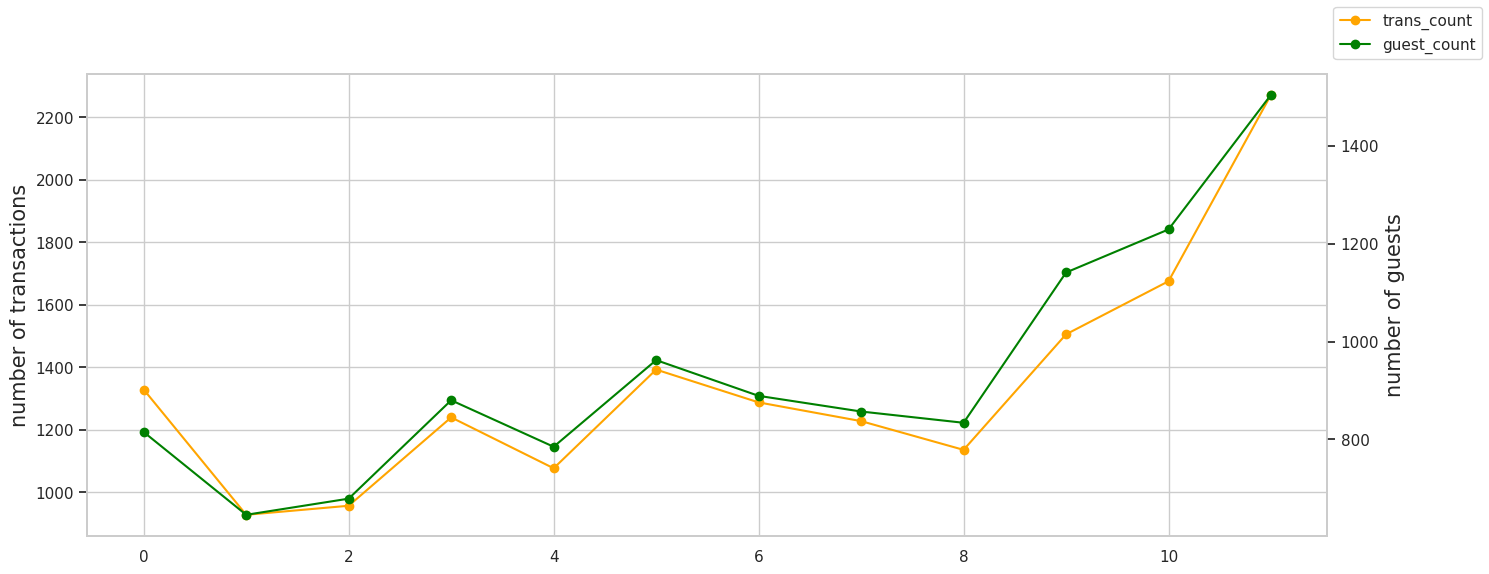

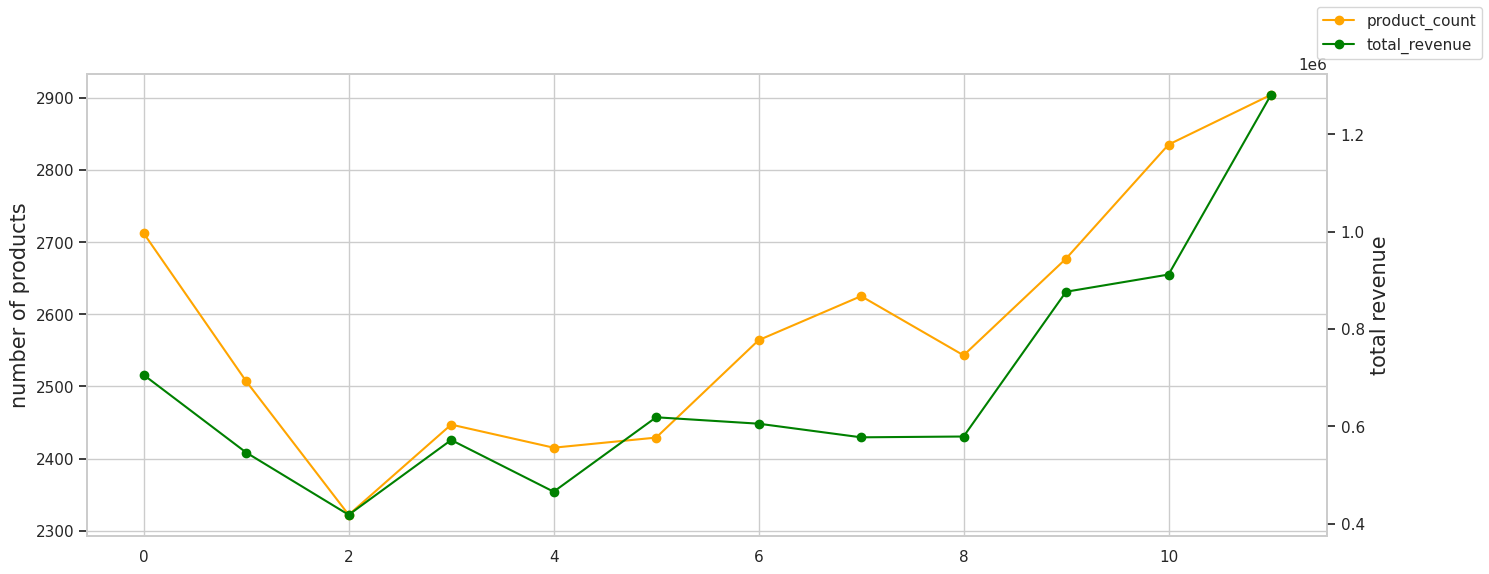

In [ ]:
graph (month_trend_pd)

# Trend by Day of Week

In [ ]:
week_trend = temp_df.groupBy('invoice_date_only','day_of_week')\
.agg(F.countDistinct('InvoiceDate').alias('trans_count'),F.countDistinct('CustomerID').alias('guest_count'),F.countDistinct('Description').alias('product_count'),F.round(F.sum('revenue'),0).alias('total_revenue'))\
.groupBy('day_of_week')\
.agg(F.avg('trans_count').alias('trans_count'),F.avg('guest_count').alias('guest_count'),F.avg('product_count').alias('product_count'),F.round(F.avg('total_revenue'),0).alias('total_revenue'))\
.sort(F.col('day_of_week'))
week_trend.show()
week_trend_pd = week_trend.toPandas()

+-----------+-----------------+------------------+-----------------+-------------+
|day_of_week|      trans_count|       guest_count|    product_count|total_revenue|
+-----------+-----------------+------------------+-----------------+-------------+
|          0|55.08510638297872| 49.87234042553192|944.9574468085107|      31080.0|
|          1|57.30769230769231|             51.75|            911.5|      34772.0|
|          2|57.83018867924528|53.490566037735846|868.1698113207547|      28184.0|
|          3|66.79245283018868|  62.0188679245283|900.6415094339623|      32926.0|
|          4|            51.62|             44.86|            808.8|      30281.0|
|          6|            38.82|              38.3|           687.44|      14098.0|
+-----------+-----------------+------------------+-----------------+-------------+



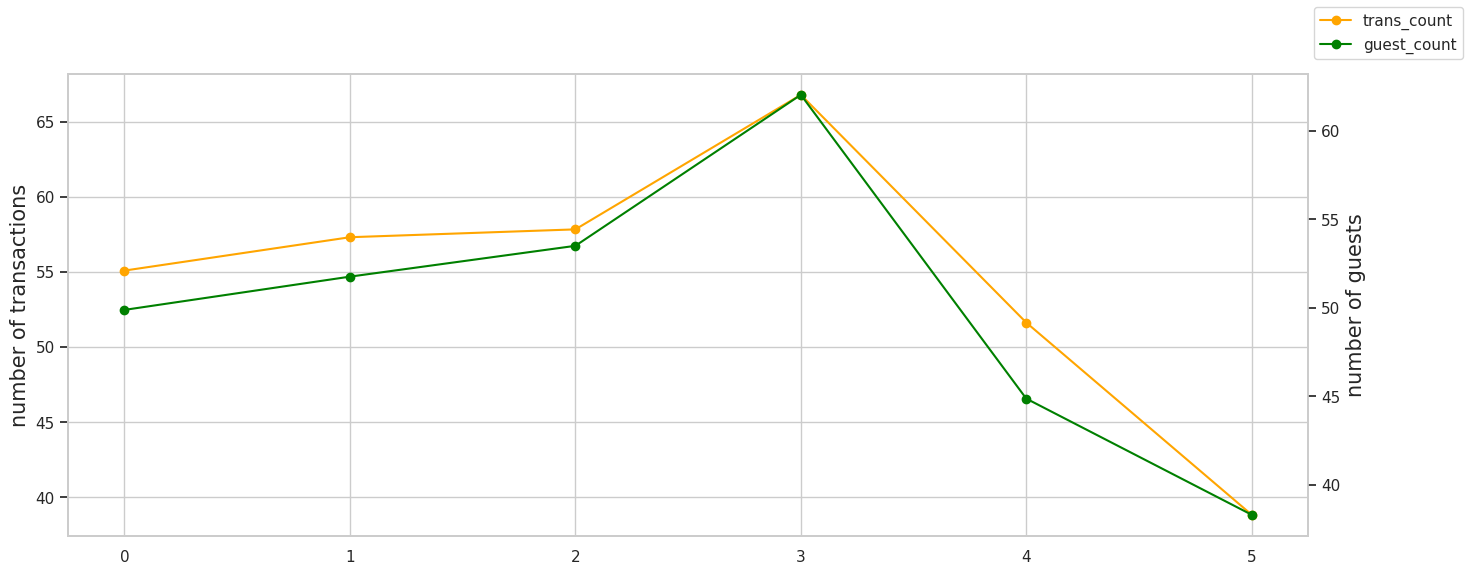

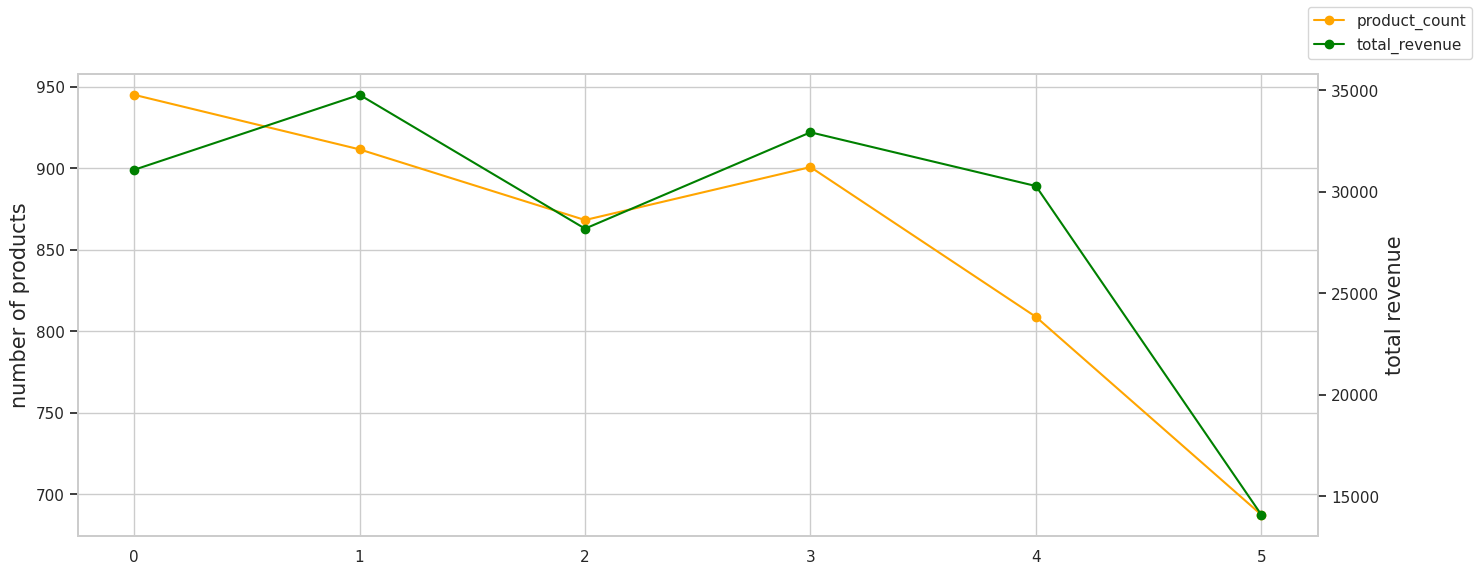

In [ ]:
graph (week_trend_pd)

# Popular Items

In [ ]:
df1 = temp_df.filter(F.col('Country').isin('United Kingdom')).groupBy('Description').agg(F.countDistinct('InvoiceDate').alias('trans_count')).orderBy(F.desc('trans_count'))
windowSpec  = Window.partitionBy()
df1 = df1.withColumn("perc_dis",F.col('trans_count')/(F.sum('trans_count').over(windowSpec)))
df1.toPandas().head(20)


,Description,trans_count,perc_dis
0,WHITE HANGING HEART T-LIGHT HOLDER,2085,0.004647
1,JUMBO BAG RED RETROSPOT,1824,0.004065
2,REGENCY CAKESTAND 3 TIER,1623,0.003617
3,PARTY BUNTING,1557,0.003470
4,LUNCH BAG RED RETROSPOT,1332,0.002969
5,ASSORTED COLOUR BIRD ORNAMENT,1316,0.002933
6,SET OF 3 CAKE TINS PANTRY DESIGN,1199,0.002672
7,NATURAL SLATE HEART CHALKBOARD,1166,0.002599
8,LUNCH BAG BLACK SKULL.,1166,0.002599
9,HEART OF WICKER SMALL,1127,0.002512


In [ ]:
windowSpec  = Window.partitionBy()
df2 = temp_df.filter(F.col('Country').isin('United Kingdom')).groupBy('StockCode','Description').agg(F.sum('revenue').alias('total_revenue')).orderBy(F.desc('total_revenue'))
df2 = df2.withColumn("perc_dis",F.col('total_revenue')/(F.sum('total_revenue').over(windowSpec))).orderBy(F.desc('total_revenue')).limit(20)

df2.toPandas()

,StockCode,Description,total_revenue,perc_dis
0,22423,REGENCY CAKESTAND 3 TIER,137470.62,0.016856
1,85123A,WHITE HANGING HEART T-LIGHT HOLDER,96734.29,0.011861
2,47566,PARTY BUNTING,92760.15,0.011374
3,85099B,JUMBO BAG RED RETROSPOT,84230.60,0.010328
4,23166,MEDIUM CERAMIC TOP STORAGE JAR,80372.84,0.009855
5,22086,PAPER CHAIN KIT 50'S CHRISTMAS,55833.48,0.006846
6,84879,ASSORTED COLOUR BIRD ORNAMENT,52426.74,0.006428
7,79321,CHILLI LIGHTS,50675.42,0.006214
8,22502,PICNIC BASKET WICKER 60 PIECES,39619.50,0.004858
9,22386,JUMBO BAG PINK POLKADOT,37651.45,0.004617


In [ ]:
promo_list = ['85123A','84879','21212','21977','85099B','22197','22178','22616','17003','84077']
df2.filter(F.col('StockCode').isin(promo_list)).toPandas().head(20)
#JUMBO BAG RED RETROSPOT,WHITE HANGING HEART T-LIGHT HOLDER	,VICTORIAN GLASS HANGING T-LIGHT

,StockCode,Description,total_revenue,perc_dis
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,96734.29,0.011861
1,85099B,JUMBO BAG RED RETROSPOT,84230.60,0.010328
2,84879,ASSORTED COLOUR BIRD ORNAMENT,52426.74,0.006428
3,22178,VICTORIAN GLASS HANGING T-LIGHT,30395.76,0.003727
4,22197,POPCORN HOLDER,27428.92,0.003363
5,22197,SMALL POPCORN HOLDER,15815.05,0.001939
6,21212,PACK OF 72 RETROSPOT CAKE CASES,15313.75,0.001878
7,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,11916.79,0.001461
8,21977,PACK OF 60 PINK PAISLEY CAKE CASES,9845.44,0.001207
9,22616,PACK OF 12 LONDON TISSUES,7427.49,0.000911


In [ ]:
##items with top transations and top revenue
df1.limit(20).join(df2.limit(20),'Description','inner').toPandas()

,Description,trans_count,perc_dis,StockCode,total_revenue,perc_dis
0,REGENCY CAKESTAND 3 TIER,1623,0.003617,22423,137470.62,0.016856
1,WHITE HANGING HEART T-LIGHT HOLDER,2085,0.004647,85123A,96734.29,0.011861
2,PARTY BUNTING,1557,0.003470,47566,92760.15,0.011374
3,JUMBO BAG RED RETROSPOT,1824,0.004065,85099B,84230.60,0.010328
4,PAPER CHAIN KIT 50'S CHRISTMAS,1000,0.002229,22086,55833.48,0.006846
5,ASSORTED COLOUR BIRD ORNAMENT,1316,0.002933,84879,52426.74,0.006428
6,JUMBO BAG PINK POLKADOT,1086,0.002420,22386,37651.45,0.004617
7,SPOTTY BUNTING,1004,0.002238,23298,36423.07,0.004466
8,HEART OF WICKER SMALL,1127,0.002512,22469,31086.82,0.003812
9,SET OF 3 CAKE TINS PANTRY DESIGN,1199,0.002672,22720,28997.29,0.003556


# select item that is promo list

In [ ]:
promo_list = ['85123A','84879','21212','21977','85099B','22197','22178','22616','17003','84077']

top_10 = temp_df.filter(F.col('StockCode').isin(promo_list))\
.withColumn('StockCode_int',F.substring(col('StockCode'),1,5))\
.withColumn("StockCode_int", col('StockCode_int').cast(IntegerType()))

# top_10.toPandas().to_csv('/content/drive/My Drive/top_10.csv', index=False)

In [ ]:
top_10 =pd.read_csv('/content/drive/My Drive/top_10.csv')
top_10_ps_df = spark.createDataFrame(top_10)

In [ ]:
# Getting unique Name and Brand Name mapping list
product_mapping = top_10[['StockCode','Description']].drop_duplicates()
product_mapping

,StockCode,Description
0,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS
219,84879,ASSORTED COLOUR BIRD ORNAMENT
902,85099B,JUMBO BAG RED RETROSPOT
1811,17003,BROCADE RING PURSE
1911,21212,PACK OF 72 RETROSPOT CAKE CASES
2483,22616,PACK OF 12 LONDON TISSUES
2727,21977,PACK OF 60 PINK PAISLEY CAKE CASES
3112,22197,SMALL POPCORN HOLDER
3119,22197,POPCORN HOLDER
3742,22178,VICTORIAN GLASS HANGING T-LIGHT


# select only top 20 items

In [ ]:
top_20 = temp_df.join(df2.select('StockCode'),'StockCode','inner')\
.withColumn('StockCode_int',F.substring(col('StockCode'),1,5))\
.withColumn("StockCode_int", col('StockCode_int').cast(IntegerType()))
# .select('invoice_year','InvoiceNo','Quantity','revenue','StockCode','Description','CustomerID','invoice_date_only','StockCode_int','UnitPrice','invoice_month','day_of_week')

# top_20.toPandas().to_csv('/content/drive/My Drive/top_20.csv', index=False)

# read saved top 20 df

In [ ]:
top_20 =pd.read_csv('/content/drive/My Drive/top_20.csv')
top_20_ps_df = spark.createDataFrame(top_20)

In [ ]:
month_trend = top_20_ps_df.groupBy('invoice_year','invoice_month')\
.agg(F.countDistinct('InvoiceNo').alias('trans_count'),F.countDistinct('CustomerID').alias('guest_count'),F.countDistinct('Description').alias('product_count'),F.round(F.sum('revenue'),0).alias('total_revenue'))\
.orderBy(F.desc('trans_count'))\
.sort(F.col('invoice_year'),F.col('invoice_month'))

month_trend_pd = month_trend.toPandas()
month_trend_pd

,invoice_year,invoice_month,trans_count,guest_count,product_count,total_revenue
0,2010,12,734,496,16,87111.0
1,2011,1,560,410,17,138289.0
2,2011,2,545,404,16,45290.0
3,2011,3,728,547,16,71976.0
4,2011,4,592,457,17,52352.0
5,2011,5,918,668,21,88810.0
6,2011,6,802,588,22,113981.0
7,2011,7,748,548,20,75673.0
8,2011,8,677,521,20,71108.0
9,2011,9,896,723,20,78813.0


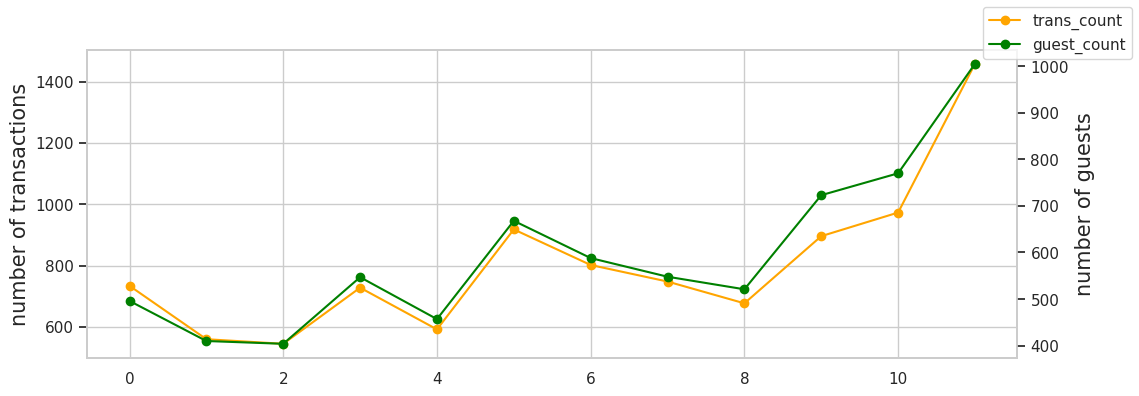

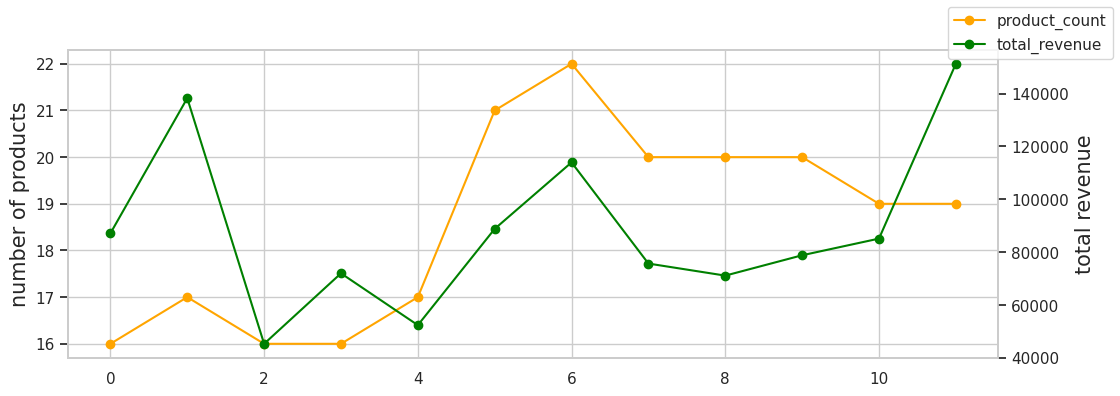

In [ ]:
graph(month_trend_pd)

In [ ]:
week_trend = top_20_ps_df.groupBy('invoice_date_only','day_of_week')\
.agg(F.countDistinct('InvoiceNo').alias('trans_count'),F.countDistinct('CustomerID').alias('guest_count'),F.countDistinct('Description').alias('product_count'),F.round(F.sum('revenue'),0).alias('total_revenue'))\
.groupBy('day_of_week')\
.agg(F.avg('trans_count').alias('trans_count'),F.avg('guest_count').alias('guest_count'),F.avg('product_count').alias('product_count'),F.round(F.avg('total_revenue'),0).alias('total_revenue'))\
.sort(F.col('day_of_week'))

week_trend_pd = week_trend.toPandas()
week_trend_pd

,day_of_week,trans_count,guest_count,product_count,total_revenue
0,0,32.804348,29.500000,15.804348,3372.0
1,1,34.411765,29.745098,15.686275,5536.0
2,2,33.730769,30.730769,15.326923,3346.0
3,3,38.568627,36.078431,15.666667,3853.0
4,4,28.958333,25.458333,15.458333,3841.0
5,6,25.632653,25.163265,13.653061,1377.0


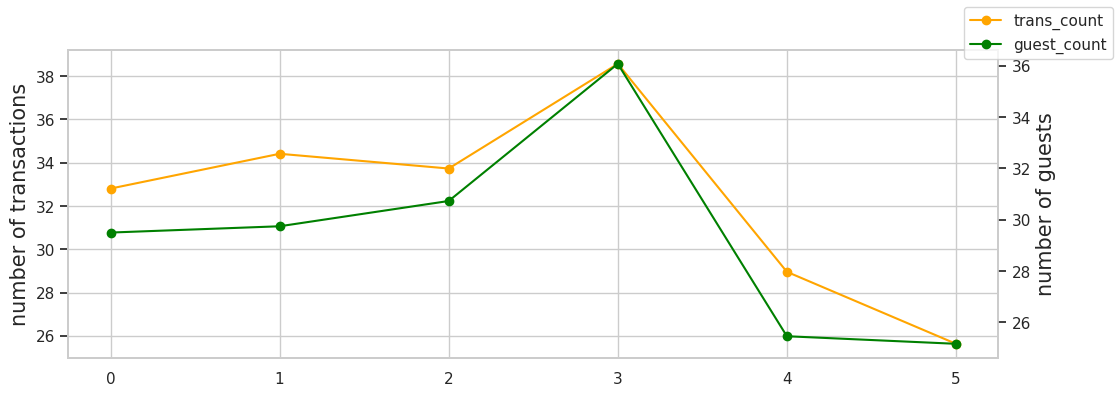

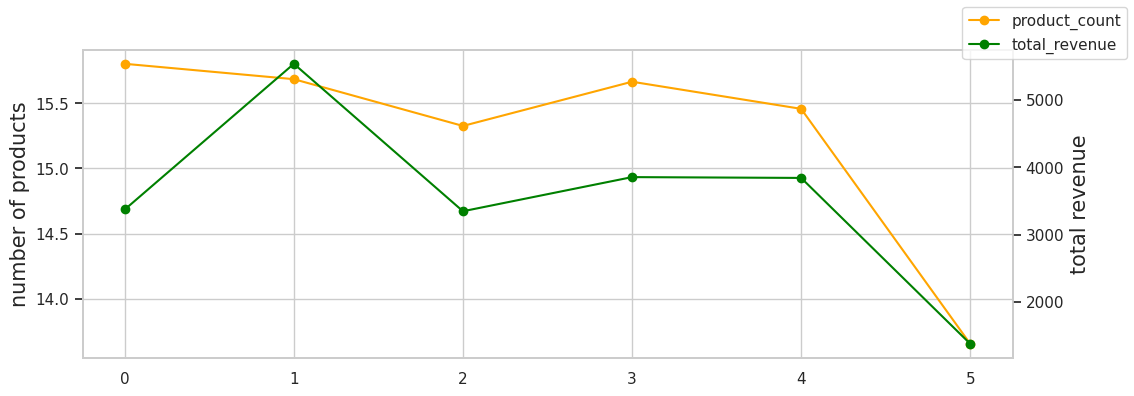

In [ ]:
graph(week_trend_pd)

In [ ]:
# seasonality_df = top_20.groupBy('Description','invoice_date_only','day_of_week').agg(F.avg('UnitPrice').alias('avg_price'),F.sum('Quantity').alias('total_qty')).groupBy('Description','day_of_week').agg(F.avg('avg_price').alias('avg_price'),F.avg('total_qty').alias('total_qty'))
# seasonality_pd_df = seasonality_df.toPandas()
# seasonality_pd_df.to_csv('/content/drive/My Drive/day_of_wk_price_qty.csv', index=False)
##JUMBO BAG RED RETROSPOT,WHITE HANGING HEART T-LIGHT HOLDER	,VICTORIAN GLASS HANGING T-LIGHT

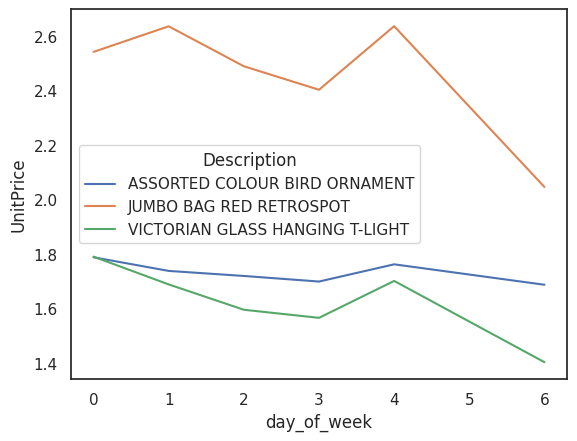

In [ ]:
Week_price_df = top_20.groupby(['invoice_date_only', 'day_of_week','Description']).agg({'UnitPrice':'mean','Quantity':'sum'}).groupby([ 'day_of_week','Description']).agg({'UnitPrice':'mean','Quantity':'mean'}).reset_index()
Week_price_df
sns.lineplot(x='day_of_week', y='UnitPrice', hue='Description', data=Week_price_df[(Week_price_df.Description =='ASSORTED COLOUR BIRD ORNAMENT')|(Week_price_df.Description =='JUMBO BAG RED RETROSPOT')|(Week_price_df.Description =='VICTORIAN GLASS HANGING T-LIGHT')])
plt.show()


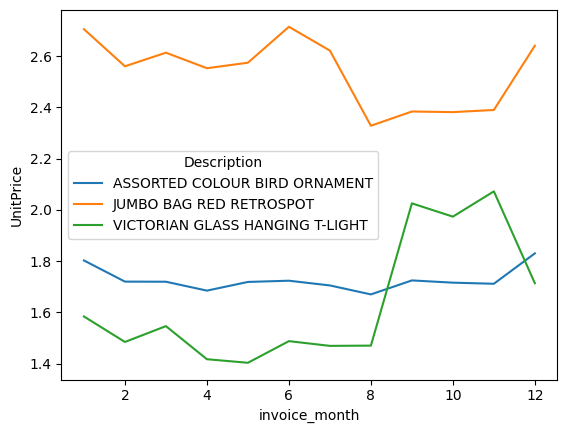

In [ ]:
month_price_df = top_20.groupby(['invoice_month','Description']).agg({'UnitPrice':'mean','Quantity':'sum'}).reset_index()
month_price_df
sns.lineplot(x='invoice_month', y='UnitPrice', hue='Description', data=month_price_df[(month_price_df.Description =='ASSORTED COLOUR BIRD ORNAMENT')|(month_price_df.Description =='JUMBO BAG RED RETROSPOT')|(month_price_df.Description =='VICTORIAN GLASS HANGING T-LIGHT')])
plt.show()

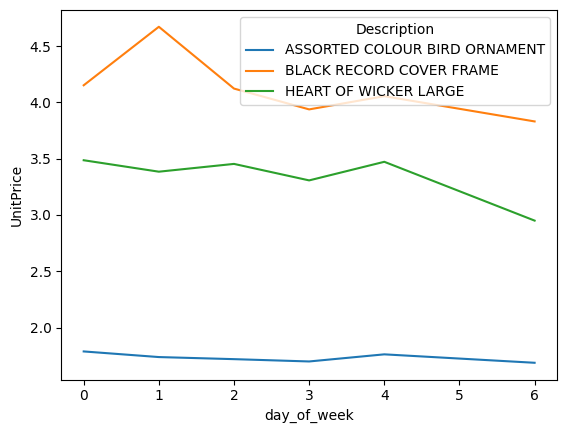

In [ ]:
Week_price_df = top_20.groupby(['invoice_date_only', 'day_of_week','Description']).agg({'UnitPrice':'mean','Quantity':'sum'}).groupby([ 'day_of_week','Description']).agg({'UnitPrice':'mean','Quantity':'mean'}).reset_index()
Week_price_df
sns.lineplot(x='day_of_week', y='UnitPrice', hue='Description', data=Week_price_df[(Week_price_df.Description =='ASSORTED COLOUR BIRD ORNAMENT')|(Week_price_df.Description =='BLACK RECORD COVER FRAME')|(Week_price_df.Description =='HEART OF WICKER LARGE')])
plt.show()


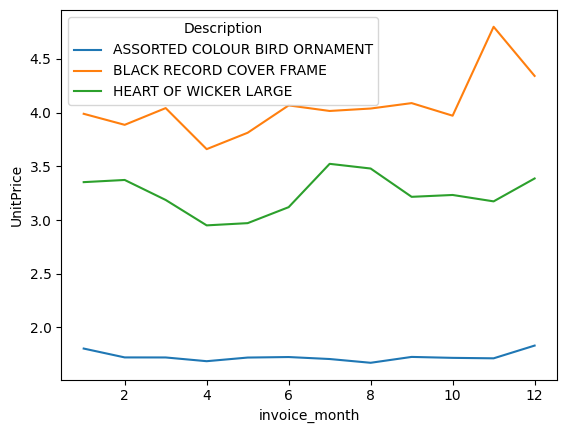

In [ ]:
month_price_df = top_20.groupby(['invoice_month','Description']).agg({'UnitPrice':'mean','Quantity':'sum'}).reset_index()
month_price_df
sns.lineplot(x='invoice_month', y='UnitPrice', hue='Description', data=month_price_df[(month_price_df.Description =='ASSORTED COLOUR BIRD ORNAMENT')|(month_price_df.Description =='BLACK RECORD COVER FRAME')|(month_price_df.Description =='HEART OF WICKER LARGE')])
plt.show()

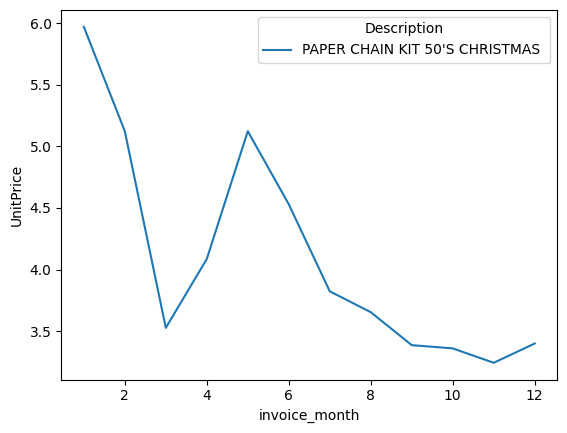

In [ ]:
sns.lineplot(x='invoice_month', y='UnitPrice', hue='Description', data=month_price_df[month_price_df['Description'].str.contains('CHRISTMAS')])
plt.show()

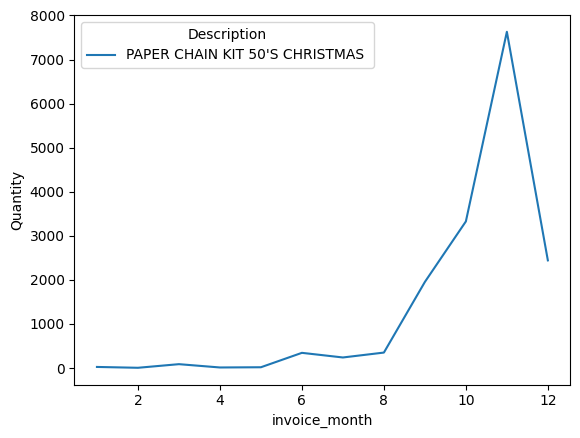

In [ ]:
sns.lineplot(x='invoice_month', y='Quantity', hue='Description', data=month_price_df[month_price_df['Description'].str.contains('CHRISTMAS')])
plt.show()

In [ ]:
sns.lineplot(x='invoice_month', y='UnitPrice', hue='Description', data=month_price_df[month_price_df['Description'].str.contains('CHRISTMAS')])
plt.show()

+--------------------+-------------+------------------+
|         Description|invoice_month|         avg_price|
+--------------------+-------------+------------------+
|      SPOTTY BUNTING|           11| 5.655098039215681|
|SET OF 3 CAKE TIN...|            5| 6.409999999999999|
|VICTORIAN GLASS H...|           11|2.0724000000000005|
|MEDIUM CERAMIC TO...|            5|         1.3684375|
|  RABBIT NIGHT LIGHT|            7|3.5605555555555557|
|BLACK RECORD COVE...|           12| 4.341923076923076|
|PICNIC BASKET WIC...|            9|            4.9625|
|WOOD BLACK BOARD ...|            1| 7.495384615384613|
|ASSORTED COLOUR B...|            8|1.6701834862385312|
|WOOD BLACK BOARD ...|            8| 9.830769230769228|
|JUMBO BAG STRAWBERRY|            3| 2.238095238095239|
|       CHILLI LIGHTS|            3| 6.787708333333335|
|MEDIUM CERAMIC TO...|            1|              1.04|
|HEART OF WICKER S...|            3| 2.138444444444444|
|JUMBO BAG STRAWBERRY|           11|2.3508571428

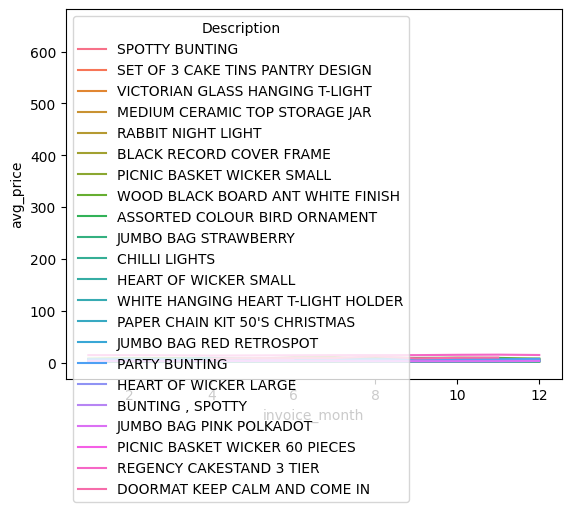

In [ ]:
seasonality_df = top_20.groupBy('Description','invoice_month').agg(F.avg('UnitPrice').alias('avg_price'))
seasonality_pd_df = seasonality_df.toPandas()
seasonality_df.to_csv('/content/drive/My Drive/month_price.csv', index=False)
sns.lineplot(x='invoice_month', y='avg_price', hue='Description', data=seasonality_pd_df)
plt.show()

+--------------------+-------------+---------+
|         Description|invoice_month|total_qty|
+--------------------+-------------+---------+
|      SPOTTY BUNTING|           11|      831|
|SET OF 3 CAKE TIN...|            5|       17|
|VICTORIAN GLASS H...|           11|     1674|
|MEDIUM CERAMIC TO...|            5|      681|
|  RABBIT NIGHT LIGHT|            7|       96|
|BLACK RECORD COVE...|           12|     1836|
|PICNIC BASKET WIC...|            9|        7|
|WOOD BLACK BOARD ...|            1|      326|
|ASSORTED COLOUR B...|            8|     6489|
|WOOD BLACK BOARD ...|            8|      257|
|JUMBO BAG STRAWBERRY|            3|     2770|
|       CHILLI LIGHTS|            3|      477|
|MEDIUM CERAMIC TO...|            1|    74215|
|HEART OF WICKER S...|            3|      932|
|JUMBO BAG STRAWBERRY|           11|      878|
|WHITE HANGING HEA...|           12|     3633|
|PAPER CHAIN KIT 5...|           10|     3326|
|JUMBO BAG RED RET...|           11|     5571|
|       PARTY

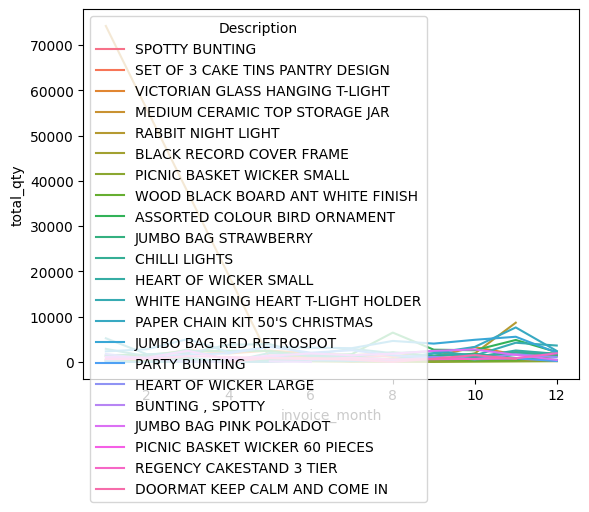

In [ ]:
seasonality_df = top_20.groupBy('Description','invoice_month').agg(F.sum('Quantity').alias('total_qty'))
seasonality_df.show()
seasonality_pd_df = seasonality_df.toPandas()
sns.lineplot(x='invoice_month', y='total_qty', hue='Description', data=seasonality_pd_df)
plt.show()

In [ ]:
##null value check, passed
from functools import reduce

top_20.where(reduce(lambda x, y: x | y, (col(x).isNull() for x in top_20.columns))).limit(1).collect()

[]

In [ ]:
top_20.summary().show()

+-------+-----------------+-----------------+-----------------+-----------------+------------------+
|summary|         Quantity|    StockCode_int|        UnitPrice|    invoice_month|       day_of_week|
+-------+-----------------+-----------------+-----------------+-----------------+------------------+
|  count|            20411|            20411|            20411|            20411|             20411|
|   mean|18.28004507373475|46774.06016363725|4.792206653275086|7.084758218607614|2.4716574396158935|
| stddev|521.9773827542026|28980.62538063701|7.503864839942553|3.362438922302251|1.8473381386130225|
|    min|                1|            21137|              0.9|                1|                 0|
|    25%|                2|            22423|             2.08|                4|                 1|
|    50%|                5|            23284|             2.95|                7|                 2|
|    75%|               12|            84879|             4.95|               10|          

In [ ]:
# from functools import reduce

# # Check if the list returned by collect() is empty using len()
# is_empty = len(top_20.where(reduce(lambda x, y: x | y, (col(x).isNull() for x in top_20.columns))).limit(1).collect()) == 0

# # Print the result
# print(is_empty)  # Output: True or False

False


In [ ]:
# temp_df.join(df2.select('StockCode'),'StockCode','inner')\
# .withColumn('StockCode_int',F.substring(col('StockCode'),1,5))\
# .withColumn("StockCode_int", col('StockCode_int').cast(IntegerType()))\
# .filter(col('StockCode_int').isNull())\
# .show()

+---------+---------+-----------+--------+-----------+---------+----------+-------+-------+------------+-----------------+-------------+------------+-----------+---------------+-------------+
|StockCode|InvoiceNo|Description|Quantity|InvoiceDate|UnitPrice|CustomerID|Country|revenue|invoice_date|invoice_date_only|invoice_month|invoice_year|day_of_week|day_of_week_str|StockCode_int|
+---------+---------+-----------+--------+-----------+---------+----------+-------+-------+------------+-----------------+-------------+------------+-----------+---------------+-------------+
+---------+---------+-----------+--------+-----------+---------+----------+-------+-------+------------+-----------------+-------------+------------+-----------+---------------+-------------+



In [ ]:
pricing_df1 = top_20_ps_df.groupBy('Description').agg(F.countDistinct('UnitPrice').alias('distinct_price'),F.max('UnitPrice').alias('max_price'),F.min('UnitPrice').alias('min_price'),F.mean('UnitPrice').alias('mean_price'),F.skewness('UnitPrice').alias('skew'),F.countDistinct('CustomerID').alias('distinct_guest')).sort('distinct_price')

In [ ]:
windowSpec  = Window.partitionBy('Description')
pricing_df2 = top_20_ps_df.groupBy('Description','UnitPrice')\
.agg(F.countDistinct('CustomerID').alias('distinct_guest'))\
.withColumn("perc_dis",F.col('distinct_guest')/(F.sum('distinct_guest').over(windowSpec)))\
.withColumn("dense_rank",F.dense_rank().over(windowSpec.orderBy(F.desc("distinct_guest"))))\
.filter(col('dense_rank')==1)

pricing_df1.join(pricing_df2,'Description','full').toPandas()


,Description,distinct_price,max_price,min_price,mean_price,skew,distinct_guest,UnitPrice,distinct_guest,perc_dis,dense_rank
0,ASSORTED COLOUR BIRD ORNAMENT,5,3.19,1.35,1.723457,5.171923,631,1.69,617,0.953632,1
1,BLACK RECORD COVER FRAME,4,7.62,3.39,4.207523,1.854379,126,3.75,103,0.762963,1
2,"BUNTING , SPOTTY",2,4.95,4.15,4.721429,-0.948683,7,4.95,5,0.714286,1
3,CHILLI LIGHTS,14,17.88,3.82,6.739280,1.497070,198,5.75,147,0.574219,1
4,DOORMAT KEEP CALM AND COME IN,8,16.63,4.58,8.754110,2.192834,350,7.95,181,0.405830,1
5,HEART OF WICKER LARGE,9,6.95,1.97,3.283037,2.307263,478,2.95,463,0.942974,1
6,HEART OF WICKER SMALL,11,4.21,1.10,1.966745,1.893950,550,1.65,519,0.902609,1
7,JUMBO BAG PINK POLKADOT,10,5.06,1.65,2.626580,1.004771,340,2.08,266,0.621495,1
8,JUMBO BAG RED RETROSPOT,11,4.95,1.65,2.522576,1.167911,556,2.08,453,0.614654,1
9,JUMBO BAG STRAWBERRY,9,4.95,1.65,2.399478,1.559966,291,2.08,219,0.598361,1


In [ ]:
top_20_ps_df.filter(col('Description').isin('JUMBO BAG PINK POLKADOT'))\
.groupBy('UnitPrice')\
.agg(F.countDistinct('CustomerID').alias('distinct_guest'),F.sum('Quantity').alias('Quantity'))\
.sort('UnitPrice')\
.toPandas()

,UnitPrice,distinct_guest,Quantity
0,1.65,9,3140
1,1.74,1,1200
2,1.75,1,600
3,1.79,20,6730
4,1.95,126,1637
5,2.08,266,4488
6,4.13,2,1070
7,4.21,1,20
8,4.96,1,28
9,5.06,1,23


from matplotlib import pyplot as plt
_df_22['UnitPrice'].plot(kind='hist', bins=20, title='UnitPrice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_23['distinct_guest'].plot(kind='hist', bins=20, title='distinct_guest')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_24['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_25.plot(kind='scatter', x='UnitPrice', y='distinct_guest', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_26.plot(kind='scatter', x='distinct_guest', y='Quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['distinct_guest']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('distinct_guest')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['Quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_28.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('Quantity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['UnitPrice']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'UnitPrice'}, axis=1)
              .sort_values('UnitPrice', ascending=True))
  xs = counted['UnitPrice']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_29.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_30['UnitPrice'].plot(kind='line', figsize=(8, 4), title='UnitPrice')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_31['distinct_guest'].plot(kind='line', figsize=(8, 4), title='distinct_guest')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_32['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

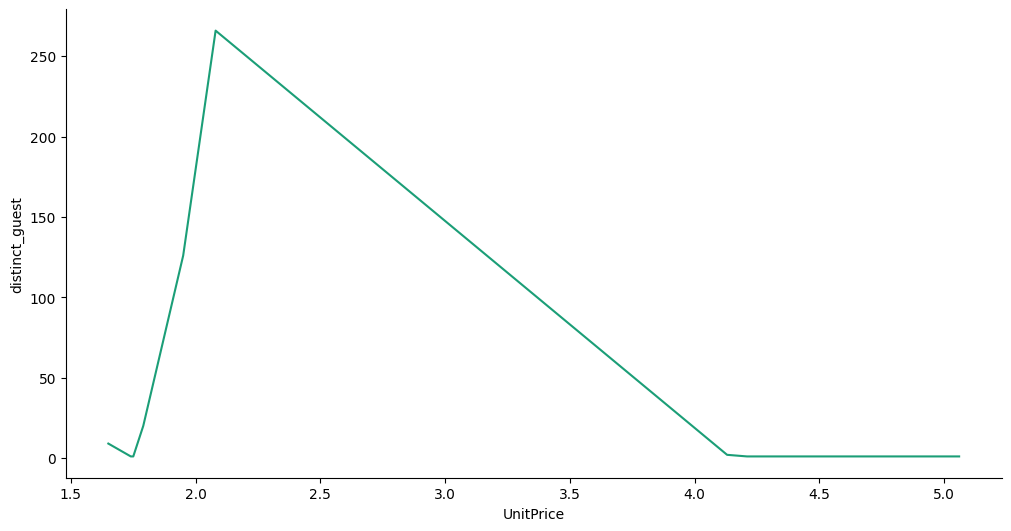

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['distinct_guest']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_27.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('distinct_guest')

In [ ]:
top_20_ps_df.filter(col('Description').isin('PICNIC BASKET WICKER SMALL'))\
.groupBy('UnitPrice')\
.agg(F.countDistinct('CustomerID').alias('distinct_guest'),F.sum('Quantity').alias('Quantity'))\
.sort('UnitPrice')\
.toPandas()

,UnitPrice,distinct_guest,Quantity
0,2.00,1,1
1,4.95,21,623
2,5.95,150,669
3,8.29,1,185
4,8.47,1,56
5,8.95,1,30
6,10.79,1,150


from matplotlib import pyplot as plt
_df_11['UnitPrice'].plot(kind='hist', bins=20, title='UnitPrice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_12['distinct_guest'].plot(kind='hist', bins=20, title='distinct_guest')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_14.plot(kind='scatter', x='UnitPrice', y='distinct_guest', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15.plot(kind='scatter', x='distinct_guest', y='Quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['distinct_guest']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_16.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('distinct_guest')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['Quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_17.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('Quantity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['UnitPrice']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'UnitPrice'}, axis=1)
              .sort_values('UnitPrice', ascending=True))
  xs = counted['UnitPrice']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_18.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_19['UnitPrice'].plot(kind='line', figsize=(8, 4), title='UnitPrice')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['distinct_guest'].plot(kind='line', figsize=(8, 4), title='distinct_guest')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_21['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

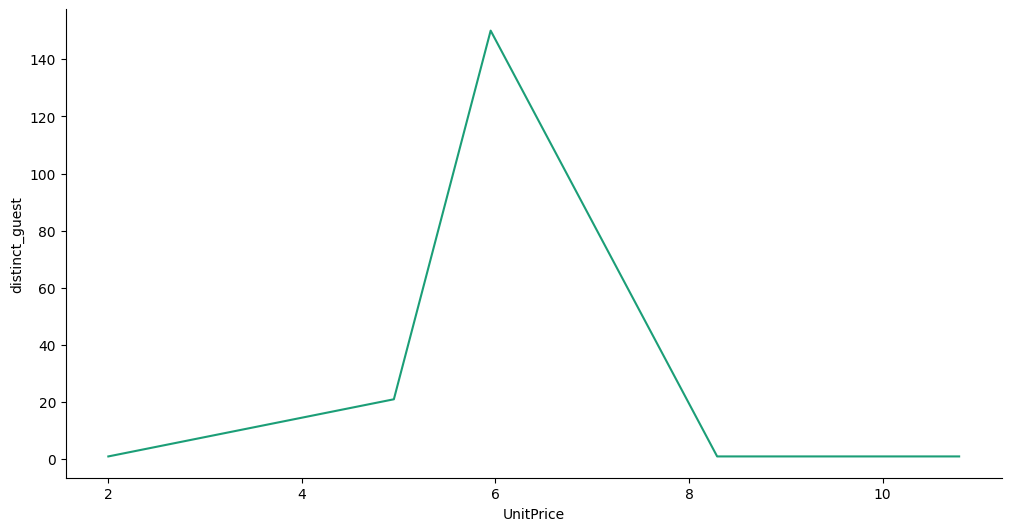

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['distinct_guest']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_16.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('distinct_guest')

In [ ]:
top_20_ps_df.filter(col('Description').isin('ASSORTED COLOUR BIRD ORNAMENT'))\
.groupBy('UnitPrice')\
.agg(F.countDistinct('CustomerID').alias('distinct_guest'),F.sum('Quantity').alias('Quantity'))\
.sort('UnitPrice')\
.toPandas()

,UnitPrice,distinct_guest,Quantity
0,1.35,1,176
1,1.45,27,11496
2,1.69,617,20186
3,3.12,1,336
4,3.19,1,112


from matplotlib import pyplot as plt
_df_0['UnitPrice'].plot(kind='hist', bins=20, title='UnitPrice')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['distinct_guest'].plot(kind='hist', bins=20, title='distinct_guest')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Quantity'].plot(kind='hist', bins=20, title='Quantity')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='UnitPrice', y='distinct_guest', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='distinct_guest', y='Quantity', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['distinct_guest']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('distinct_guest')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['Quantity']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('Quantity')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['UnitPrice']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'UnitPrice'}, axis=1)
              .sort_values('UnitPrice', ascending=True))
  xs = counted['UnitPrice']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['UnitPrice'].plot(kind='line', figsize=(8, 4), title='UnitPrice')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['distinct_guest'].plot(kind='line', figsize=(8, 4), title='distinct_guest')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['Quantity'].plot(kind='line', figsize=(8, 4), title='Quantity')
plt.gca().spines[['top', 'right']].set_visible(False)

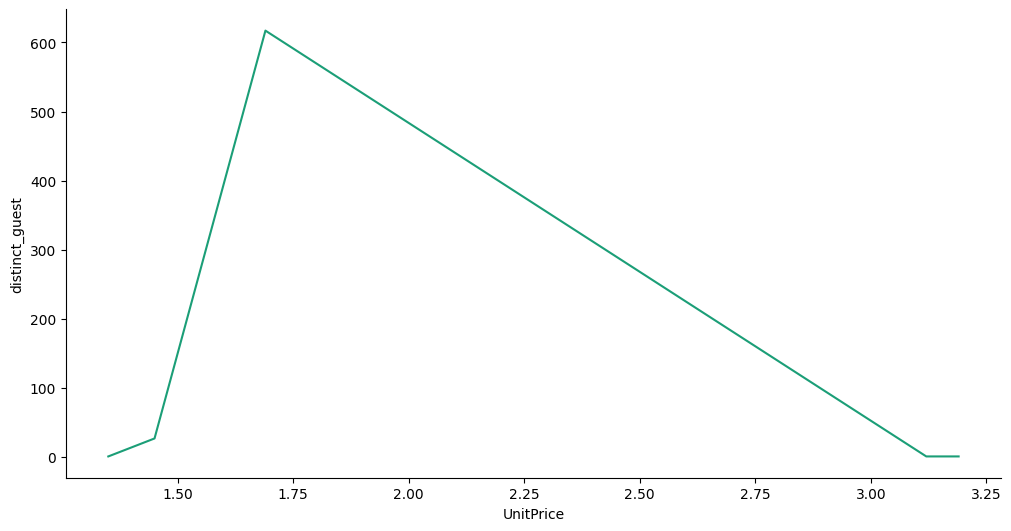

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['UnitPrice']
  ys = series['distinct_guest']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('UnitPrice', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('UnitPrice')
_ = plt.ylabel('distinct_guest')

In [ ]:
## each customer fets different prices

# top_20_ps_df.groupBy('CustomerID').pivot('Description').agg(F.avg('UnitPrice')).show()
##one product how many price points, per price points transaction units customer, centralized or not, colorcoded by season
##add seasonality feature into the model, price point and units sold

In [ ]:

##dominant buyer
windowSpec  = Window.partitionBy('Description')
top_20_ps_df.groupBy('Description','CustomerID')\
.agg(F.sum('Quantity').alias('total_purchase'))\
.withColumn("perc_dis",F.col('total_purchase')/(F.sum('total_purchase').over(windowSpec)))\
.withColumn("dense_rank",F.dense_rank().over(windowSpec.orderBy(F.desc("total_purchase"))))\
.filter(col('dense_rank')==1)\
.sort(F.desc('perc_dis'))\
.toPandas()


,Description,CustomerID,total_purchase,perc_dis,dense_rank
0,PICNIC BASKET WICKER 60 PIECES,15098.0,61,1.000000,1
1,MEDIUM CERAMIC TOP STORAGE JAR,12346.0,74215,0.965373,1
2,WOOD BLACK BOARD ANT WHITE FINISH,18102.0,2989,0.543553,1
3,HEART OF WICKER LARGE,17450.0,4282,0.440989,1
4,"BUNTING , SPOTTY",17809.0,60,0.410959,1
5,BLACK RECORD COVER FRAME,16210.0,3768,0.387296,1
6,HEART OF WICKER SMALL,17450.0,5286,0.304546,1
7,PICNIC BASKET WICKER SMALL,NaN,452,0.263711,1
8,DOORMAT KEEP CALM AND COME IN,18102.0,1200,0.232378,1
9,RABBIT NIGHT LIGHT,NaN,2917,0.226880,1


# Feature Enginnering and Model Building

In [ ]:
top_10.head(1)
# top_10_ps_df

,StockCode,InvoiceNo,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,revenue,invoice_date,invoice_date_only,invoice_month,invoice_year,day_of_week,day_of_week_str,StockCode_int
0,23284,556245,DOORMAT KEEP CALM AND COME IN,1,2011-06-09 16:10:00,7.95,17841.0,United Kingdom,7.95,2011-06-09 16:10:00,2011-06-09,6,2011,3,Thu,23284


In [ ]:
top_10_features = top_10[['StockCode','Quantity','UnitPrice','invoice_month','day_of_week']]
# top_20[['Quantity','UnitPrice','invoice_month','day_of_week']]

In [ ]:
dummy_variable_columns = ['day_of_week', 'invoice_month']
sales_dataframe_new = pd.get_dummies(top_10_features, columns=dummy_variable_columns)

# Convert specific columns to integers, excluding 'StockCode'
int_cols = [col for col in sales_dataframe_new.columns if col != 'StockCode' and col != 'Description'and col != 'UnitPrice']
sales_dataframe_new[int_cols] = sales_dataframe_new[int_cols].astype(int)

In [ ]:
# dummy_variable_columns = ['day_of_week', 'invoice_month']
# sales_dataframe_new = pd.get_dummies(top_10_features, columns=dummy_variable_columns)

In [ ]:
sales_dataframe_new[[col for col in sales_dataframe_new.columns if col != 'Quantity' and col != 'StockCode']]

,UnitPrice,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_6,invoice_month_1,invoice_month_2,invoice_month_3,invoice_month_4,invoice_month_5,invoice_month_6,invoice_month_7,invoice_month_8,invoice_month_9,invoice_month_10,invoice_month_11,invoice_month_12
0,0.42,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0.29,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0.29,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0.29,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,0.43,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10616,2.95,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
10617,2.95,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
10618,2.95,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
10619,5.79,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
sales_dataframe_new[[col for col in sales_dataframe_new.columns if col != 'Quantity' and col != 'StockCode']].to_numpy()

array([[0.42, 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.29, 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [0.29, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [2.95, 0.  , 1.  , ..., 0.  , 0.  , 0.  ],
       [5.79, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       [2.95, 0.  , 0.  , ..., 0.  , 1.  , 0.  ]])

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
# Import r2_score for calculating R-squared
from sklearn.metrics import r2_score


for i in sales_dataframe_new.StockCode.unique():
  sales_dataframe_new_v1=sales_dataframe_new[sales_dataframe_new['StockCode'] == i]
  # Set up the train and test sets
  train_x, test_x, train_y, test_y = train_test_split(sales_dataframe_new_v1[[col for col in sales_dataframe_new_v1.columns if col != 'Quantity' and col != 'StockCode']].to_numpy(), sales_dataframe_new_v1['Quantity'].to_numpy(), test_size=0.20, random_state=20)

  # Standardize the feature vector and target vector
  scaler = preprocessing.StandardScaler().fit(train_x)
  train_x_scaled = scaler.transform(train_x)
  test_x_scaled = scaler.transform(test_x)

  # Build and fit the linear regression model
  model = LinearRegression() # Now lr is an sklearn LinearRegression object
  model .fit(train_x_scaled, train_y)

  # make predictions
  yhat = model .predict(test_x_scaled)  # Use lr to predict, and test_x_scaled for prediction
  # evaluate predictions
  mae = mean_absolute_error(test_y, yhat) # Use test_y for evaluation
  mape= mean_absolute_percentage_error(test_y, yhat)
  # Calculate R-squared and assign it to a valid variable name (R_squared)
  R_squared = r2_score(test_y, yhat)

  print({i},'mape: %.3f' % mape,'mae: %.3f' % mae,'R^2: %.3f' % R_squared) # Print R_squared

{'84077'} mape: 7.321 mae: 127.570 R^2: 0.040
{'84879'} mape: 2.035 mae: 19.710 R^2: -0.449
{'85099B'} mape: 4.119 mae: 25.056 R^2: 0.104
{'17003'} mape: 12.026 mae: 134.026 R^2: 0.034
{'21212'} mape: 5.503 mae: 20.537 R^2: 0.000
{'22616'} mape: 6.634 mae: 77.870 R^2: 0.012
{'21977'} mape: 7.496 mae: 33.533 R^2: -0.015
{'22197'} mape: 5.791 mae: 52.609 R^2: -0.075
{'22178'} mape: 2.545 mae: 23.259 R^2: 0.076
{'85123A'} mape: 3.111 mae: 23.308 R^2: 0.010


In [ ]:
# from sklearn.linear_model import LinearRegression
# import numpy as np
# import sklearn
# from sklearn.model_selection import train_test_split
# from sklearn import preprocessing
# from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
# # Import r2_score for calculating R-squared
# from sklearn.metrics import r2_score


# for i in sales_dataframe_new.StockCode.unique():
#   sales_dataframe_new_v1=sales_dataframe_new[sales_dataframe_new['StockCode'] == i]
#   # Set up the train and test sets
#   train_x, test_x, train_y, test_y = train_test_split(sales_dataframe_new_v1[[col for col in sales_dataframe_new_v1.columns if col != 'Quantity' and col != 'StockCode']].to_numpy(), sales_dataframe_new_v1['Quantity'].to_numpy(), test_size=0.20, random_state=20)

#   # # Standardize the feature vector and target vector
#   # scaler = preprocessing.StandardScaler().fit(train_x)
#   # train_x_scaled = scaler.transform(train_x)
#   # test_x_scaled = scaler.transform(test_x)

#   # Build and fit the linear regression model
#   model = LinearRegression() # Now lr is an sklearn LinearRegression object
#   model .fit(train_x, train_y)

#   # make predictions
#   yhat = model .predict(test_x)  # Use lr to predict, and test_x_scaled for prediction
#   # evaluate predictions
#   mae = mean_absolute_error(test_y, yhat) # Use test_y for evaluation
#   mape= mean_absolute_percentage_error(test_y, yhat)
#   # Calculate R-squared and assign it to a valid variable name (R_squared)
#   R_squared = r2_score(test_y, yhat)

#   # print({i},'mape: %.3f' % mape,'mae: %.3f' % mae,'R^2: %.3f' % R_squared)

{'84077'} mape: 7.321 mae: 127.570 R^2: 0.040
{'84879'} mape: 2.035 mae: 19.710 R^2: -0.449
{'85099B'} mape: 4.119 mae: 25.056 R^2: 0.104
{'17003'} mape: 12.026 mae: 134.026 R^2: 0.034
{'21212'} mape: 5.503 mae: 20.537 R^2: 0.000
{'22616'} mape: 6.634 mae: 77.870 R^2: 0.012
{'21977'} mape: 7.496 mae: 33.533 R^2: -0.015
{'22197'} mape: 5.791 mae: 52.609 R^2: -0.075
{'22178'} mape: 2.545 mae: 23.259 R^2: 0.076
{'85123A'} mape: 3.111 mae: 23.308 R^2: 0.010


In [ ]:
# for i in sales_dataframe_new.StockCode.unique():
#   sales_dataframe_new=sales_dataframe_new[sales_dataframe_new['StockCode'] == i]
#   print(sales_dataframe_new.count())

# Price Elasticity

In [ ]:
# day_price_df = top_20.groupBy('invoice_date_only').agg(F.avg('UnitPrice'),F.sum('Quantity'))
x_pivot = top_10_ps_df.groupBy('StockCode').pivot('invoice_date_only').agg(F.avg('UnitPrice'))

In [ ]:

to_melt = [c for c in x_pivot.columns if c not in {'StockCode'}]
x_melt = x_pivot.melt(
        ids=['StockCode'], values=to_melt,
        variableColumnName="invoice_date_only",
        valueColumnName="avg_unit_price")
# x_melt.filter(col('StockCode').isin('23284')).show()

In [ ]:
from pyspark.sql import functions as F, Window as W

w_following = W.partitionBy('StockCode').orderBy('invoice_date_only').rowsBetween(0, W.unboundedFollowing)
w_preceding = W.partitionBy('StockCode').orderBy('invoice_date_only').rowsBetween(W.unboundedPreceding, 0)
x_melt = x_melt.withColumn(
    'avg_unit_price_new',
    F.coalesce(
        F.first('avg_unit_price', True).over(w_following),
        F.last('avg_unit_price', True).over(w_preceding)
    )
)
# x_melt.filter(col('StockCode').isin('23284')).show()


In [ ]:
x_values = x_melt.groupBy('invoice_date_only').pivot('StockCode').agg(F.first('avg_unit_price_new')).drop(F.col('invoice_date_only')).toPandas().to_records()
x_values = pd.DataFrame(x_values)

In [ ]:
x_values

,index,21137,22086,22114,22178,22197,22386,22423,22469,22502,...,23166,23284,23298,23843,47566,79321,82484,84879,85099B,85123A
0,0,3.7500,6.630000,3.950000,1.060000,1.435000,1.950000,12.300000,1.650000,5.950000,...,1.250,7.35,4.683333,2.08,4.650000,4.9500,6.450,1.6900,1.650000,2.883333
1,1,3.7500,6.630000,9.130000,1.855000,1.045000,1.950000,14.051250,1.650000,5.825000,...,1.250,7.35,4.683333,2.08,7.270000,5.8525,9.870,1.6900,2.386000,2.900000
2,2,3.7500,6.630000,3.950000,1.505000,1.110000,2.841429,13.826250,2.006364,5.950000,...,1.250,7.35,4.683333,2.08,5.523333,9.1225,6.450,1.6900,2.266000,2.883333
3,3,3.3900,6.630000,4.250000,1.250000,1.318000,2.080000,12.750000,1.650000,10.790000,...,1.250,7.95,4.950000,2.08,5.923333,5.7500,16.630,2.0475,2.080000,2.550000
4,4,3.7500,4.790000,4.250000,1.250000,1.240000,2.080000,15.192000,1.650000,5.950000,...,1.250,7.95,6.896667,2.08,5.923333,12.4600,7.550,1.6900,2.080000,2.790000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,300,3.3900,5.790000,4.250000,1.976000,1.474000,2.875714,15.620000,2.085556,8.843333,...,1.250,9.82,5.923333,2.08,4.950000,5.7500,7.350,1.6900,3.171818,3.298571
301,301,3.7500,4.370000,4.250000,1.653333,0.850000,2.373333,12.750000,2.470000,10.790000,...,1.250,7.95,6.630000,2.08,5.075714,4.8000,4.800,1.6900,2.331429,3.298571
302,302,3.7500,5.790000,4.250000,1.250000,0.850000,2.038571,12.550000,1.575000,5.950000,...,1.250,7.55,4.883333,2.08,5.399231,4.9500,7.650,1.5300,2.043750,2.835714
303,303,3.3900,4.167143,5.981429,2.205000,1.500000,3.446667,15.463333,2.630000,2.000000,...,1.145,8.25,7.870000,2.08,8.454000,9.1050,9.686,1.6900,3.122222,5.080000


In [ ]:
y_pivot = top_10_ps_df.groupBy('StockCode').pivot('invoice_date_only').agg(F.sum('Quantity'))

to_melt = [c for c in x_pivot.columns if c not in {'StockCode'}]
y_melt = y_pivot.melt(
        ids=['StockCode'], values=to_melt,
        variableColumnName="invoice_date_only",
        valueColumnName="Quantity")\
        .fillna(0)
y_values = y_melt.groupBy('invoice_date_only').pivot('StockCode').agg(F.first('Quantity')).drop('invoice_date_only').toPandas().to_records()
y_values = pd.DataFrame(y_values)

In [ ]:
y_values

,index,21137,22086,22114,22178,22197,22386,22423,22469,22502,...,23166,23284,23298,23843,47566,79321,82484,84879,85099B,85123A
0,0,0,0,0,29,57,37,31,16,41,...,0,0,0,0,0,51,4,16,51,64
1,1,0,0,0,96,0,11,35,31,2,...,0,0,0,0,13,2,15,34,100,47
2,2,0,0,1,234,34,86,49,148,1,...,0,0,0,0,71,7,5,32,373,74
3,3,0,0,0,12,0,10,13,3,0,...,2,13,3,0,0,4,0,0,30,32
4,4,0,0,0,24,33,25,13,12,0,...,0,0,30,0,70,8,0,60,45,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,300,0,0,0,37,27,323,56,106,19,...,12,13,39,0,23,1,17,56,153,353
301,301,9,7,0,49,24,137,3,2,2,...,12,1,44,0,131,528,0,56,162,58
302,302,0,0,0,27,84,136,58,0,14,...,0,29,106,0,61,120,0,328,144,120
303,303,110,96,31,24,284,252,60,53,0,...,0,155,24,0,24,78,1,184,362,80


In [ ]:
final_df = pd.DataFrame()
for col in x_values.columns[1:]:

    results_values = {
    "StockCode": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
    "rsquared": [],
    }

    temp_df1 = pd.DataFrame()
    temp_df1['x'] = x_values[col]
    temp_df1['y'] = y_values[col]
    temp_df1.dropna(inplace=True)
    x_value = temp_df1['x']
    y_value = temp_df1['y']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()

    #choose only those whose P-value is less than 5% errornous
    if result.f_pvalue < 1:

        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        try:
            intercept,slope = result.params
        except:
            slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        try:
            tintercept, t_score = result.tvalues
        except:
            print()

        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)



        #Append results into dictionary for dataframe
        results_values["StockCode"].append(col)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        results_values["rsquared"].append(rsquared)

        final_df = pd.concat([final_df,pd.DataFrame.from_dict(results_values)],axis=0,ignore_index=True)

In [ ]:
final_df

,StockCode,price_elasticity,price_mean,quantity_mean,intercept,t_score,slope,coefficient_pvalue,rsquared
0,17003,-0.439436,0.336135,75.902357,109.256574,-0.984100,-99.228728,0.325873,0.003272
1,21212,-0.095936,0.792205,82.989899,90.951635,-0.387524,-10.050095,0.698648,0.000509
2,21977,-0.677996,0.729518,67.747475,113.680000,-1.604968,-62.962857,0.109571,0.008656
3,22178,-0.865803,1.634152,76.340067,142.435523,-2.518692,-40.446344,0.012308,0.021052
4,22197,-0.819713,1.043063,159.255892,289.800092,-1.357489,-125.154685,0.175663,0.006208
5,22616,-0.991557,0.455419,82.451178,164.206260,-2.937506,-179.516235,0.003570,0.028419
6,84077,-1.128745,0.316965,161.989899,344.835156,-1.916344,-576.863399,0.056287,0.012296
7,84879,-1.518916,1.732603,108.774411,273.993593,-1.179016,-95.358939,0.239342,0.004690
8,85099B,-0.377341,2.460320,145.239057,200.043700,-1.073618,-22.275414,0.283871,0.003892
9,85123A,0.090318,3.149941,117.114478,106.536943,0.102305,3.358011,0.918584,0.000035


In [ ]:
#Map brand name with the product name to see what brand see, how much % change
#Rename the 'Description' column in product_mapping to avoid conflict
product_mapping = product_mapping.rename(columns={'Description': 'Description_product'})
final_df = final_df.merge(product_mapping,how='left',on='StockCode')
final_df[['StockCode','Description_product','price_elasticity']].iloc[2:] #Access the renamed column

,StockCode,Description_product,price_elasticity
2,21977,PACK OF 60 PINK PAISLEY CAKE CASES,-0.677996
3,22178,VICTORIAN GLASS HANGING T-LIGHT,-0.865803
4,22197,SMALL POPCORN HOLDER,-0.819713
5,22197,POPCORN HOLDER,-0.819713
6,22197,SMALL POPCORN HOLDER,-0.819713
7,22197,POPCORN HOLDER,-0.819713
8,22197,SMALL POPCORN HOLDER,-0.819713
9,22197,POPCORN HOLDER,-0.819713
10,22197,SMALL POPCORN HOLDER,-0.819713
11,22197,POPCORN HOLDER,-0.819713


# Fit on Promo Plan


In [ ]:
promo_plan =pd.read_csv('/content/drive/My Drive/Promo Plan.csv')
promo_plan_ps_df = spark.createDataFrame(promo_plan)

In [ ]:
to_melt = [c for c in promo_plan_ps_df.columns if c not in {'StockCode'}]
promo_plan_ps_df = promo_plan_ps_df.withColumnRenamed('Unnamed: 0','StockCode')
promo_plan_melt = promo_plan_ps_df.melt(
        ids=['StockCode'], values=to_melt,
        variableColumnName="InvoiceDate",
        valueColumnName="UnitPrice")

In [ ]:
price_analysis = promo_plan_melt.groupBy('StockCode').agg(F.countDistinct('UnitPrice').alias('distinct_price'),F.max('UnitPrice').alias('max_price'),F.min('UnitPrice').alias('min_price'),F.mean('UnitPrice').alias('mean_price'),F.skewness('UnitPrice').alias('skew')).sort('distinct_price')

price_analysis.toPandas()

,StockCode,distinct_price,max_price,min_price,mean_price,skew
0,84077,22,320.00,0.00,3.509896,9.643905
1,22616,23,1.37,0.00,0.520000,0.736744
2,84879,24,1.68,0.00,0.927917,0.740822
3,17003,24,0.60,0.00,0.158750,0.681619
4,21977,28,2.38,0.00,0.720729,1.263723
5,22178,28,3.35,0.00,1.869583,0.515501
6,85123A,30,161.00,1.54,4.645417,7.232369
7,85099B,33,3.04,0.00,1.594583,0.827473
8,22197,33,79.00,0.00,1.728542,9.604245
9,21212,34,780.00,0.00,9.110208,9.643332


In [ ]:
##add date time columns
spark.sql("set spark.sql.legacy.timeParserPolicy=LEGACY")
promo_plan_melt=promo_plan_melt.distinct()\
.withColumn('invoice_date',F.to_timestamp(F.col("InvoiceDate"),'yyyy-MM-dd'))\
.withColumn('invoice_date_only',F.to_date("invoice_date"))\
.withColumn('invoice_month',F.month("invoice_date"))\
.withColumn('invoice_year',F.year("invoice_date"))\
.withColumn('day_of_week', F.weekday('invoice_date'))\
.withColumn('day_of_week_str', F.date_format('invoice_date', 'E'))

In [ ]:
promo_plan_melt.select('day_of_week','day_of_week_str').distinct().show()

+-----------+---------------+
|day_of_week|day_of_week_str|
+-----------+---------------+
|          5|            Sat|
|          0|            Mon|
|          1|            Tue|
|          2|            Wed|
|          3|            Thu|
|          4|            Fri|
+-----------+---------------+



In [ ]:
promo_plan_melt_new = promo_plan_melt.withColumn('day_of_week',
    F.when(promo_plan_melt.day_of_week.isin('5'),F.regexp_replace(promo_plan_melt.day_of_week,'5','6'))\
    .otherwise(promo_plan_melt.day_of_week))

In [ ]:
promo_plan_melt_new.select('day_of_week','day_of_week_str').distinct().show()

+-----------+---------------+
|day_of_week|day_of_week_str|
+-----------+---------------+
|          1|            Tue|
|          0|            Mon|
|          2|            Wed|
|          6|            Sat|
|          4|            Fri|
|          3|            Thu|
+-----------+---------------+



In [ ]:
new_data = promo_plan_melt_new.toPandas()
new_data = new_data[['StockCode','UnitPrice','invoice_month','day_of_week']]
dummy_variable_columns = ['day_of_week', 'invoice_month']
new_data = pd.get_dummies(new_data, columns=dummy_variable_columns)

# Convert specific columns to integers, excluding 'StockCode'
int_cols = [col for col in new_data.columns if col != 'StockCode' and col != 'UnitPrice']
new_data[int_cols] = new_data[int_cols].astype(int)

In [ ]:
new_data

,StockCode,UnitPrice,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_6,invoice_month_1,invoice_month_2,invoice_month_3,invoice_month_12
0,85123A,1.85,0,1,0,0,0,0,1,0,0,0
1,21977,0.68,1,0,0,0,0,0,0,0,0,1
2,21977,0.00,0,0,0,0,1,0,0,0,0,1
3,21977,0.66,0,0,0,0,0,1,1,0,0,0
4,85123A,1.61,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
955,22197,0.83,0,0,0,1,0,0,0,0,1,0
956,22178,1.66,0,0,0,0,0,1,1,0,0,0
957,17003,0.00,0,0,1,0,0,0,0,0,1,0
958,84077,0.25,0,1,0,0,0,0,0,1,0,0


In [ ]:
new_data_np= new_data[[col for col in new_data.columns if col != 'Quantity' and col != 'StockCode']].to_numpy()

In [ ]:
from sklearn.linear_model import LinearRegression
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
# Import r2_score for calculating R-squared
from sklearn.metrics import r2_score


for i in sales_dataframe_new.StockCode.unique():
  sales_dataframe_new_v1=sales_dataframe_new[sales_dataframe_new['StockCode'] == i]
  # Set up the train and test sets
  train_x, test_x, train_y, test_y = train_test_split(sales_dataframe_new_v1[[col for col in sales_dataframe_new_v1.columns if col != 'Quantity' and col != 'StockCode']].to_numpy(), sales_dataframe_new_v1['Quantity'].to_numpy(), test_size=0.20, random_state=20)

  # Standardize the feature vector and target vector
  scaler = preprocessing.StandardScaler().fit(train_x)
  train_x_scaled = scaler.transform(train_x)
  test_x_scaled = scaler.transform(test_x)

  # Build and fit the linear regression model
  model = LinearRegression() # Now lr is an sklearn LinearRegression object
  model.fit(train_x_scaled, train_y)

  new_data_np=new_data_np[new_data_np['StockCode'] == i]
  prediction = model.predict(train_x_scaled)
  pred = model.predict(new_data_np)
  print(pred)
  # # make predictions
  # yhat = model .predict(test_x_scaled)  # Use lr to predict, and test_x_scaled for prediction
  # # evaluate predictions
  # mae = mean_absolute_error(test_y, yhat) # Use test_y for evaluation
  # mape= mean_absolute_percentage_error(test_y, yhat)
  # # Calculate R-squared and assign it to a valid variable name (R_squared)
  # R_squared = r2_score(test_y, yhat)

  # print({i},'mape: %.3f' % mape,'mae: %.3f' % mae,'R^2: %.3f' % R_squared) # Print R_squared

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
model = xgb_reg.fit(X, y)
prediction = model.predict(X)
new_data = [[10, 10, 10]]
new_data_asarray = np.asarray(new_data)
pred = model.predict(new_data_asarray)
print(pred)